In [1]:
%matplotlib inline

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import matplotlib_venn as venn
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer


import warnings
color = sns.color_palette()
warnings.filterwarnings("ignore")
eng_stopwords = set(stopwords.words("english"))
tokenizer = TweetTokenizer()
lem = WordNetLemmatizer()

In [2]:
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')
# sub = pd.read_csv(r'sample_submission.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

Some of these comments that do not have any flags are actually clean. Let's determine how many there are.

In [5]:
rowsums = train.iloc[:, 2:].sum(axis=1)
train['clean'] = (rowsums == 0)

In [6]:
print('Number of clean comments: {:,} or {:.2%}'.format(train['clean'].sum(), train['clean'].sum() / train.shape[0]))

Number of clean comments: 143,346 or 89.83%


In [7]:
# train['comment_text'].loc[train['toxic'] == 1][:1].values[0]

Let's take a peak at some of these comments

In [8]:
# Display one comment from each label
# for i in train.columns[2:]:
#     print('[{}] \t {}'.format(i, train['comment_text'].loc[train[i] == 1][:1].values[0]))

What a bunch of meanies.

It looks like a comment can have multiple classifications (ie being toxic as well as obscene and an insult).

Text(0.5, 0, 'Label ')

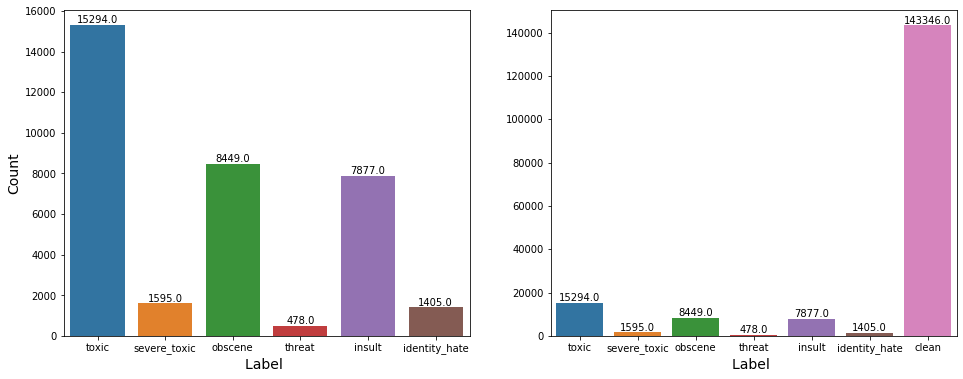

In [9]:
w = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].iloc[:].sum(axis=0)
x = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']].iloc[:].sum(axis=0)


fig, ax = plt.subplots(1,2, figsize=(16,6))
a = sns.barplot(w.index, w.values, ax=ax[0])
b = sns.barplot(x.index, x.values, ax=ax[1])

rects = b.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    b.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
    
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Label ', fontsize=14)
b.set_xlabel('Label ', fontsize=14)

As expected, the label counts are not evenly distributed. Toxic comments heavily outweight any other label, while threats are quite rare.

However, toxic comments may have multiple labels.

Text(0.5, 0, 'Number of multi-label counts ')

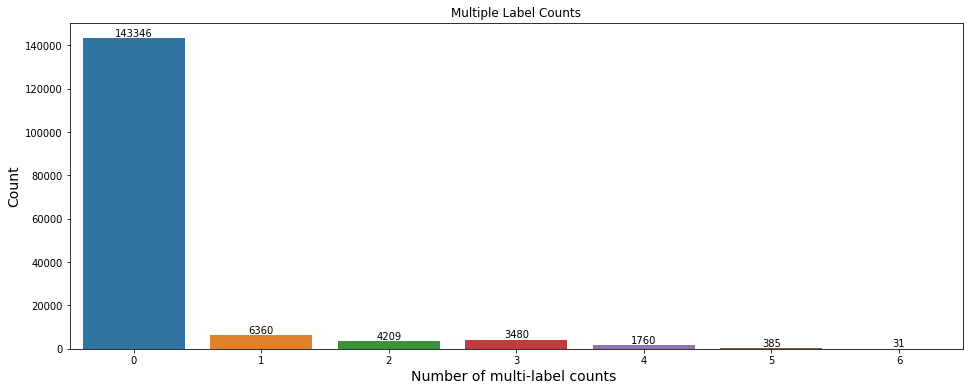

In [10]:
x = rowsums.value_counts()


fig, ax = plt.subplots(1,1, figsize=(16,6))
a = sns.barplot(x.index, x.values)


rects = a.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    a.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')

a.set_title('Multiple Label Counts')
a.set_ylabel('Count', fontsize=14)
a.set_xlabel('Number of multi-label counts ', fontsize=14)

In [11]:
main_col = "toxic"
corr_mats = []
temp_df = train.iloc[:, 2:-1]

for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

# cell highlighting

def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]



out = out.style.apply(highlight_min, axis=0)
out

From the above chart which shows the counts of labels, we see that:
    - toxic = 15294
    - severe_toxic = 1595
    - obscene = 8449
    - threat = 478
    - insult = 7877
    - identity_hate = 1405
    
So now from the confusion matrix above, we can see that:
1. A severe_toxic comment is **always** toxic
2. Almost all obscene comments are toxic
3. Almost all threats, insults, and identity are toxic

## WordCloud - Most Frequent Words

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Initalize stopwords
stopword = set(STOPWORDS)

In [13]:
# dfclean = train[train['clean'] == True]
# cleanComments = dfclean['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(cleanComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Clean Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [14]:
# dftoxic = train.loc[train['toxic'] == 1]
# toxicComments = dftoxic['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(toxicComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Toxic Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [15]:
# dfSeveretoxic = train.loc[train['severe_toxic'] == 1]
# SeveretoxicComments = dfSeveretoxic['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(SeveretoxicComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Severe Toxic Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [16]:
# dfobscene = train.loc[train['obscene'] == 1]
# obsceneComments = dfobscene['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(obsceneComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Obscene Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [17]:
# dfthreat = train.loc[train['threat'] == 1]
# threatComments = dfobscene['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(threatComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Threat Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [18]:
# dfinsult = train.loc[train['insult'] == 1]
# insultComments = dfinsult['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(insultComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Insult Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

In [19]:
# dfhate = train.loc[train['identity_hate'] == 1]
# hateComments = dfhate['comment_text'].values

# cloud = WordCloud(background_color='black', max_words=2000, stopwords=stopword)
# cloud.generate(" ".join(hateComments))
# plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.title("Most Frequent Words - Hate Comments", fontsize=20)
# plt.imshow(cloud.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
# plt.show()

## Data Cleanup & Feature Engineering

In [20]:
# Merge train & test dataset and reset index

merged = pd.concat([train.iloc[:, 0:2], test.iloc[:, 0:2]])
df = merged.reset_index(drop=True)

In [21]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Note that if we remove punctuation, we will end up removing complete sentences. Instead we will count various metrics in order to further understand the data.

In [22]:
# Find the number of new lines '\n'
df['sentenceCount'] = df['comment_text'].apply(lambda x: len(re.findall("\n", str(x))) + 1)

In [23]:
# Number of words 
df['wordCount'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Unique number of words
df['uniqueWordCount'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))

# Number of letters
df['letterCount'] = df['comment_text'].apply(lambda x: len(str(x)))

# Punctuation count
df['puncCount'] = df['comment_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Number of uppercase words
df["uppercaseCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# Number of titled words (words starting with capital letter)
df["titleWordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
df["stopwordCount"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword]))

# Average word length
df["meanWordLength"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Unique word count percentage
df['wordCountPercent'] = np.round(df['uniqueWordCount'] / df['wordCount'] * 100, 2)

# Punctuation percentage per comment
df['puncPercent'] = np.round(df['puncCount'] / df['wordCount'] * 100, 2)

In [24]:
# Seperate Train/Test data
trainFeatures = df.iloc[0:len(train)]
testFeatures = df.iloc[len(train) :,]

# Join tags
trainTags = train.iloc[:, 2:]
trainFeatures = pd.concat([trainFeatures, trainTags], axis=1)

- Are comments with more punctuation more toxic?
- Are longer comments more toxic?

In [25]:
# trainFeatures.loc[df['wordCount']]

In [26]:
trainFeatures[['wordCount', 'toxic']].sort_values(by='wordCount', ascending=False).shape

(159571, 2)

In [27]:
trainFeatures['wordCount'].loc[trainFeatures['toxic'] == 0].describe()

count    144277.000000
mean         68.967874
std          98.279574
min           1.000000
25%          18.000000
50%          38.000000
75%          78.000000
max        1250.000000
Name: wordCount, dtype: float64

Text(0.5, 1.0, 'Punc Count vs Toxicity')

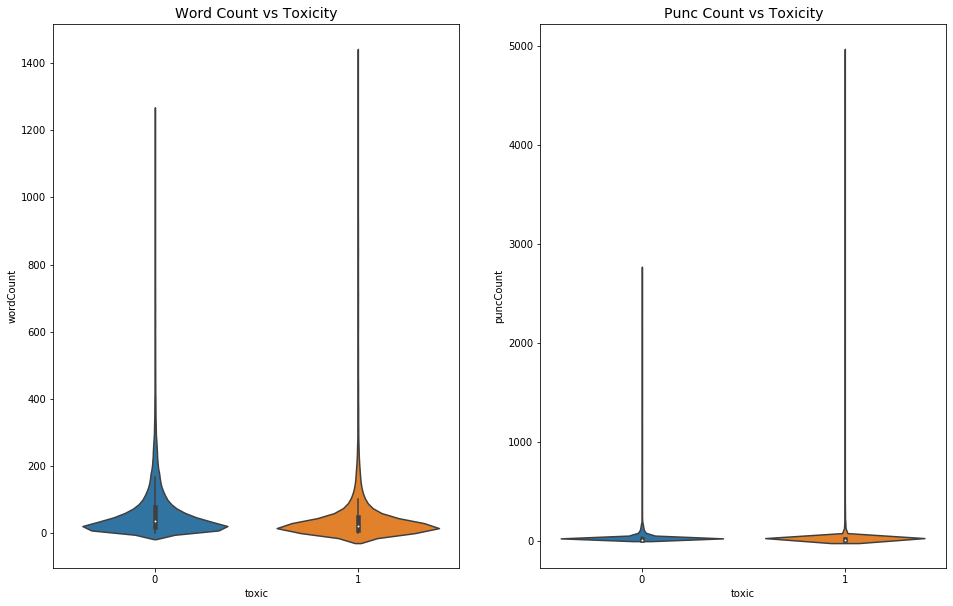

In [28]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
a = sns.violinplot(x='toxic', y='wordCount', data=trainFeatures, ax=ax[0])
b = sns.violinplot(x='toxic', y='puncCount', data=trainFeatures, ax=ax[1])

a.set_title('Word Count vs Toxicity', fontsize=14)
b.set_title('Punc Count vs Toxicity', fontsize=14)

As per violin plots, neither word count nor punctuation count seems to affect toxicity. There are huge outliers which may indicate toxic comments are more 'spammy'.

We can determine 'spam' by looking at word count versus unique word count. When the ratio of unique word count to total word count is low, it would indicate spam.

In [29]:
trainFeatures['spamRatio'] = 1 - np.round(trainFeatures['uniqueWordCount'] / trainFeatures['wordCount'], 2)

In [30]:
trainFeatures.loc[trainFeatures['spamRatio'] == 1][:5].index

Int64Index([2420, 5220, 5523, 6572, 8705], dtype='int64')

In [31]:
# Let's see what this comment looks like (first 250 characters)
trainFeatures.iloc[2420][1][:250]

'FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS BOT FUCK YOU U USELESS B'

In [32]:
trainFeatures.iloc[8705][1][:250]

'BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALL'

Sure does look like spam - and toxic as well.

Text(0.5, 1.0, 'Word Count vs Toxicity')

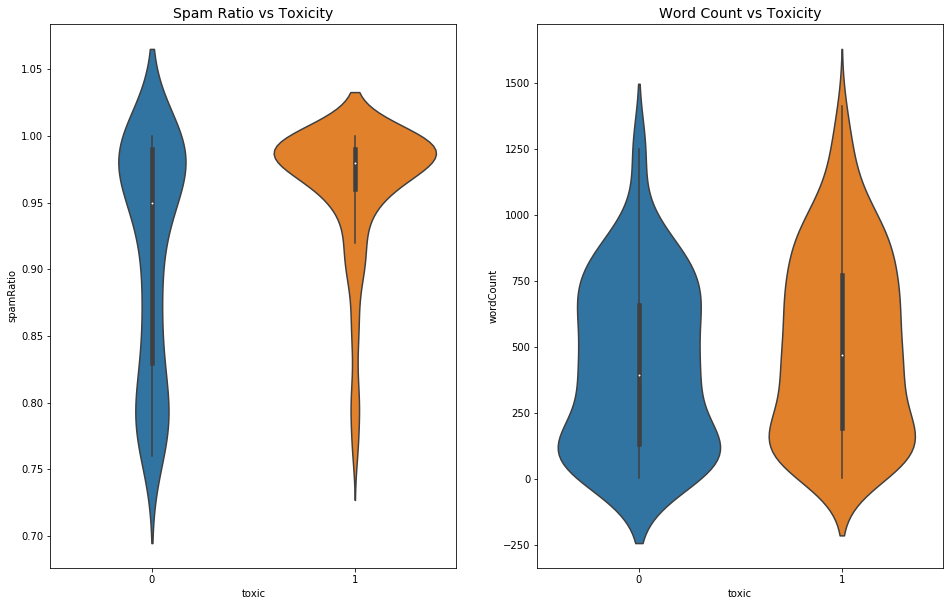

In [33]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
c = sns.violinplot(x='toxic', y='spamRatio', data=trainFeatures.loc[trainFeatures['spamRatio'] > 0.75], ax=ax[0])
d = sns.violinplot(x='toxic', y='wordCount', data=trainFeatures.loc[trainFeatures['spamRatio'] > 0.75], ax=ax[1])

c.set_title('Spam Ratio vs Toxicity', fontsize=14)
d.set_title('Word Count vs Toxicity', fontsize=14)

As predicted, spam coincides with toxicity. Spammers are more toxic!

However, it's important to note that it is possible to spam and not be toxic. Let's see what that looks like:

In [34]:
trainFeatures.loc[(trainFeatures['spamRatio'] > 0.75) & (trainFeatures['toxic'] != 1)][:5].index

Int64Index([1043, 2567, 3235, 4557, 6440], dtype='int64')

In [35]:
trainFeatures.iloc[2567][1][:250]

'Towns and Villages in Ark-La-Tex]]\n Cities, boroughs and towns in the Republic of Ireland\n Cities, boroughs, and townships along the Susquehanna River\n Cities, towns and villages in Alborz Province\n Cities, towns and villages in Ardabil Province\n Cit'

In this scenario, spam becomes toxic to our model too.

Let's create our own Count Vectorizer to pick up specific items.

In [36]:
# Leaky features
df['IP'] = df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", str(x)))

# Count of IP addresses
df['countIP'] = df["IP"].apply(lambda x: len(x))

# URLs
df['URL'] = df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))

# Count of URLs
df['countURL'] = df["URL"].apply(lambda x: len(x))

# Article IDs
df['articleID'] = df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['articleIDFlag'] = df['articleID'].apply(lambda x: len(x))

# Username
df['username'] = df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))

#count of username mentions
df['countUsernames'] = df["username"].apply(lambda x: len(x))

# check if features are created
# df.username[df.count_usernames>0]

# Leaky IP
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["IP"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))

In [37]:
# Let's check some feature names

cv.get_feature_names()[100:115]

['color',
 'colorprobe',
 'condemn',
 'contribs',
 'contributions',
 'cool',
 'corvoe',
 'crash',
 'cyphoidbomb',
 'dalbury',
 'danielfolsom',
 'dante',
 'datbitch',
 'dc',
 'ddstretch']

It may be useful to determine if we have a lot of reocurring features - such as IPs and URLs. 

In [38]:
df.columns

Index(['id', 'comment_text', 'sentenceCount', 'wordCount', 'uniqueWordCount',
       'letterCount', 'puncCount', 'uppercaseCount', 'titleWordCount',
       'stopwordCount', 'meanWordLength', 'wordCountPercent', 'puncPercent',
       'IP', 'countIP', 'URL', 'countURL', 'articleID', 'articleIDFlag',
       'username', 'countUsernames'],
      dtype='object')

In [39]:
leaky_feats = df[["IP", "URL", "articleID", "username", "countIP","countURL","countUsernames","articleIDFlag"]]

leaky_feats_train = leaky_feats.iloc[:train.shape[0]]
leaky_feats_test = leaky_feats.iloc[train.shape[0]:]

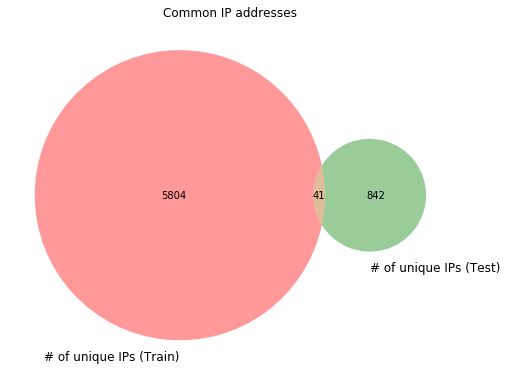

In [40]:
import matplotlib_venn as venn

# Filter out items that do not contain IPs
train_IPs = leaky_feats_train.loc[(leaky_feats_train['IP'].str.len() != 0)]
test_IPs = leaky_feats_test.loc[(leaky_feats_test['IP'].str.len() != 0)]

# Obtain list of unique IPs
train_IP_list = list(set([a for b in train_IPs['IP'].tolist() for a in b]))
test_IP_list = list(set([a for b in test_IPs['IP'].tolist() for a in b]))

# Obtain common elements
common_IP_list = list(set(train_IP_list).intersection(test_IP_list))

plt.figure(figsize=(8, 8))
plt.title("Common IP addresses")
venn.venn2(subsets=(len(train_IP_list), len(test_IP_list), len(common_IP_list)),
           set_labels=("# of unique IPs (Train)", "# of unique IPs (Test)"))
plt.show()

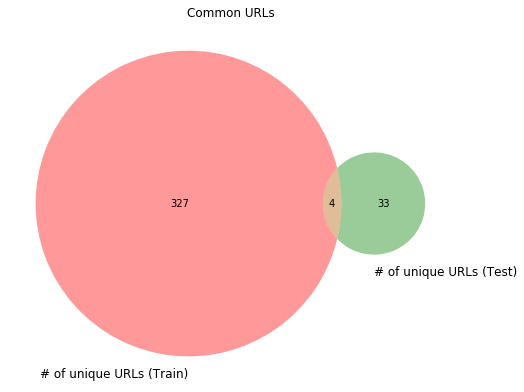

In [41]:
# Filter out items without URLs
train_URLs = leaky_feats_train.loc[(leaky_feats_train['URL'].str.len() != 0)]
test_URLs = leaky_feats_test.loc[(leaky_feats_test['URL'].str.len() != 0)]

# Obtain list of unique URLs
train_URLs_list = list(set([a for b in train_IPs['URL'].tolist() for a in b]))
test_URLs_list = list(set([a for b in test_IPs['URL'].tolist() for a in b]))

# Obtain common elements
common_URLs_list=list(set(train_URLs_list).intersection(test_URLs_list))

plt.figure(figsize=(8, 8))
plt.title("Common URLs")
venn.venn2(subsets=(len(train_URLs_list),len(test_URLs_list),len(common_URLs_list)),
           set_labels=("# of unique URLs (Train)","# of unique URLs (Test)"))
plt.show()

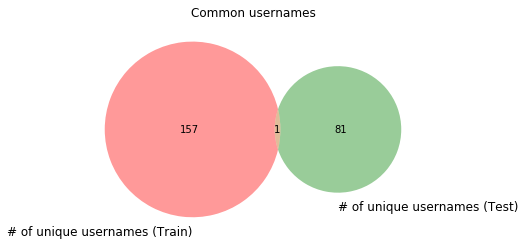

In [42]:
# Filter out items without usernames
train_users = leaky_feats_train['username'].loc[(leaky_feats_train['countUsernames'] != 0)]
test_users = leaky_feats_test['username'].loc[(leaky_feats_test['countUsernames'] != 0)]

# Obtain list of unique usernames
train_users_list = list(set([a for b in train_users.tolist() for a in b]))
test_users_list = list(set([a for b in test_users.tolist() for a in b]))
                        
# Obtain common elements
common_users_list = list(set(train_users_list).intersection(test_users_list))
                       
plt.title("Common usernames")
venn.venn2(subsets=(len(train_users_list),len(test_users_list),len(common_users_list)),
           set_labels=("# of unique usernames (Train)","# of unique usernames (Test)"))
plt.show()

The feature stability (or reoccurance) of train dataset usernames in the test dataset seems to be minimal. 

Therefore can just use the IPs/URLs in common (intersection) for test and train in our feature engineering.

Note that it may be useful to look more into these IPs - for example, there may be invalid or blocked IPs present that we would not want to interfere with our model (https://en.wikipedia.org/wiki/Wikipedia:Database_reports/Indefinitely_blocked_IPs)

### Corpus Cleaning

In [43]:
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [44]:
corpus = merged['comment_text']

In [45]:
def cleanComment(comment):
    """Takes a comment and returns cleaned copy."""
    
    # Lower case
    comment = comment.lower()
    
    # Remove '\n'
    comment = re.sub('\\n', '', comment)
    
    # Remove IPs
    comment = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', comment)
    
    # Remove username
    comment = re.sub('\[\[.*\]', '', comment)
    
    # Split comment (sentences) into words (tokens)
    words = tokenizer.tokenize(comment)
    
    # Replace apostrophes; you're --> you are  
    # using basic dictionary lookup 
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, 'v') for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    cleaned = ' '.join(words)

    return(cleaned)

In [46]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [47]:
cleanComment(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [48]:
# Clean entire corpus

%time clean_corpus = corpus.apply(lambda x: cleanComment(x))

Wall time: 1min 31s


### Direct Features

- Count Based Features (unigrams)

Let's create some features based on the frequency distribution of the words. We can start by taking words one at a time (unigrams).

- CountVectorizer 
    - Creates a matrix with frequency counts of each word in the text corpus
- TF IDF Vectorizer
    - Term Frequency: Count of the words (terms) in the corpus (same as CountVectorizer)
    - Inverse Document Frequency: Penalizes words that are too frequent (can be thought of as regularization)
- HashingVectorizer
    - Creates a hashmap (word to number mapping based on hashing technique) instead of a dictionary for words
 

In [49]:
# https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_feats(row, features, top_n=25):
    """Get top n tfidf values in row and return them with their corresponding feature names."""
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    """Top tfidf features in specific document (matrix row)"""
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    """Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids."""
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    """Return a list of dfs, where each df holds top_n features and their mean tfidf value
       calculated across documents with the same class label."""
    dfs = []
    cols=trainTags.columns
    for col in cols:
        ids = trainTags.index[trainTags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [50]:
# Parameter Descriptions

# min_df=10; ignores terms that appear less than 10 times
# max_features=None; creates as many words as present in the corpus, restricting to 10k for memory capacity
# analyzer='word'; creates features from words 
# ngram_range=(1,1); use only one word at a time (ie unigram)
# strip_accents='unicode'; removes accents
# use_idf=1, smooth_idf=1; enables IDF
# sublinear_tf=1; apply sublinear scaling - ie replace tf with 1 + log(tf)


startUnigrams = time.time()

tfv = TfidfVectorizer(min_df=200, max_features=10000, strip_accents='unicode', analyzer='word', ngram_range=(1,1),
                     use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [51]:
# Fetch top 'n' for Unigrams

tfidf_top_n_per_class = top_feats_by_class(train_unigrams, features)

endUnigrams = time.time()

print("Time to compute unigrams: {:.2f}".format(endUnigrams - startUnigrams))

Time to compute unigrams: 18.33


### TF-IDF Output

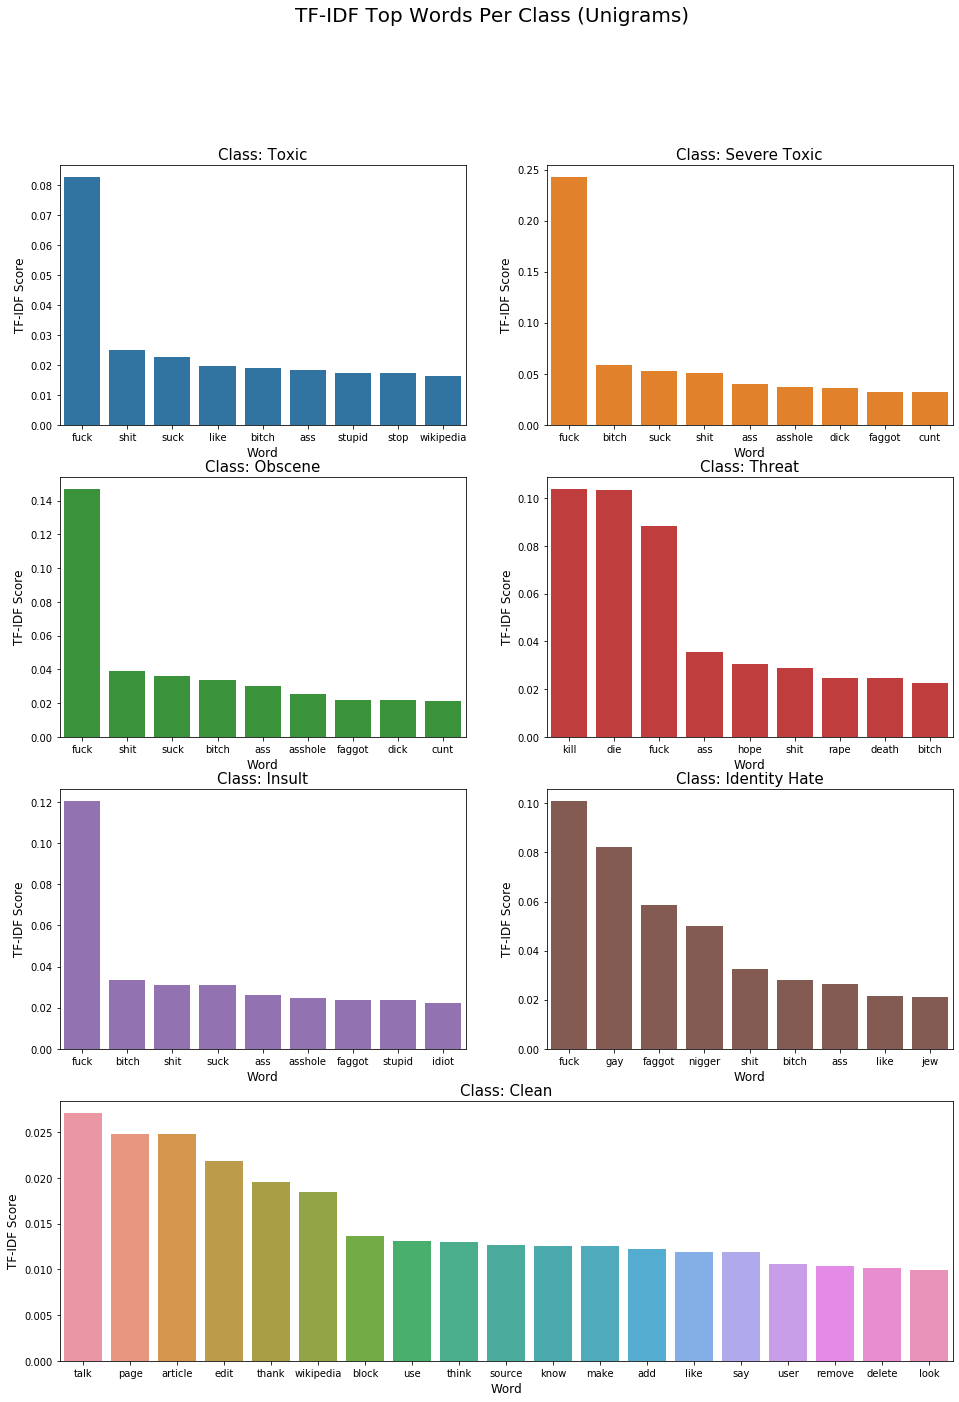

In [52]:
plt.figure(figsize=(16, 22))
plt.suptitle("TF-IDF Top Words Per Class (Unigrams)", fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2), (0,0))
sns.barplot(tfidf_top_n_per_class[0].feature.iloc[0:9], tfidf_top_n_per_class[0].tfidf.iloc[0:9], color=color[0])
plt.title("Class: Toxic", fontsize=15)
plt.xlabel("Word", fontsize=12)
plt.ylabel("TF-IDF Score", fontsize=12)

plt.subplot2grid((4,2), (0,1))
sns.barplot(tfidf_top_n_per_class[1].feature.iloc[0:9],tfidf_top_n_per_class[1].tfidf.iloc[0:9],color=color[1])
plt.title("Class: Severe Toxic", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (1,0))
sns.barplot(tfidf_top_n_per_class[2].feature.iloc[0:9],tfidf_top_n_per_class[2].tfidf.iloc[0:9],color=color[2])
plt.title("Class: Obscene", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (1,1))
sns.barplot(tfidf_top_n_per_class[3].feature.iloc[0:9],tfidf_top_n_per_class[3].tfidf.iloc[0:9],color=color[3])
plt.title("Class: Threat", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (2,0))
sns.barplot(tfidf_top_n_per_class[4].feature.iloc[0:9],tfidf_top_n_per_class[4].tfidf.iloc[0:9],color=color[4])
plt.title("Class: Insult", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_class[5].feature.iloc[0:9],tfidf_top_n_per_class[5].tfidf.iloc[0:9],color=color[5])
plt.title("Class: Identity Hate", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2),(3,0),colspan=2)
sns.barplot(tfidf_top_n_per_class[6].feature.iloc[0:19],tfidf_top_n_per_class[6].tfidf.iloc[0:19])
plt.title("Class: Clean", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)

plt.show()

Let's do the same analysis - except for Bigrams this time.

In [76]:
startBigrams = time.time()

# Set min to 150 to quickly get top features; change back to 10 for better results
tfv = TfidfVectorizer(min_df=10, max_features=30000, strip_accents='unicode', analyzer='word', ngram_range=(2,2),
                     use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_bigrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])



# Fetch top 'n' Bigrams
tfidf_top_n_per_class = top_feats_by_class(train_unigrams, features)

endBigrams = time.time()

print("Time to compute bigrams: {:.2f}".format(endBigrams - startBigrams))

Time to compute bigrams: 35.90


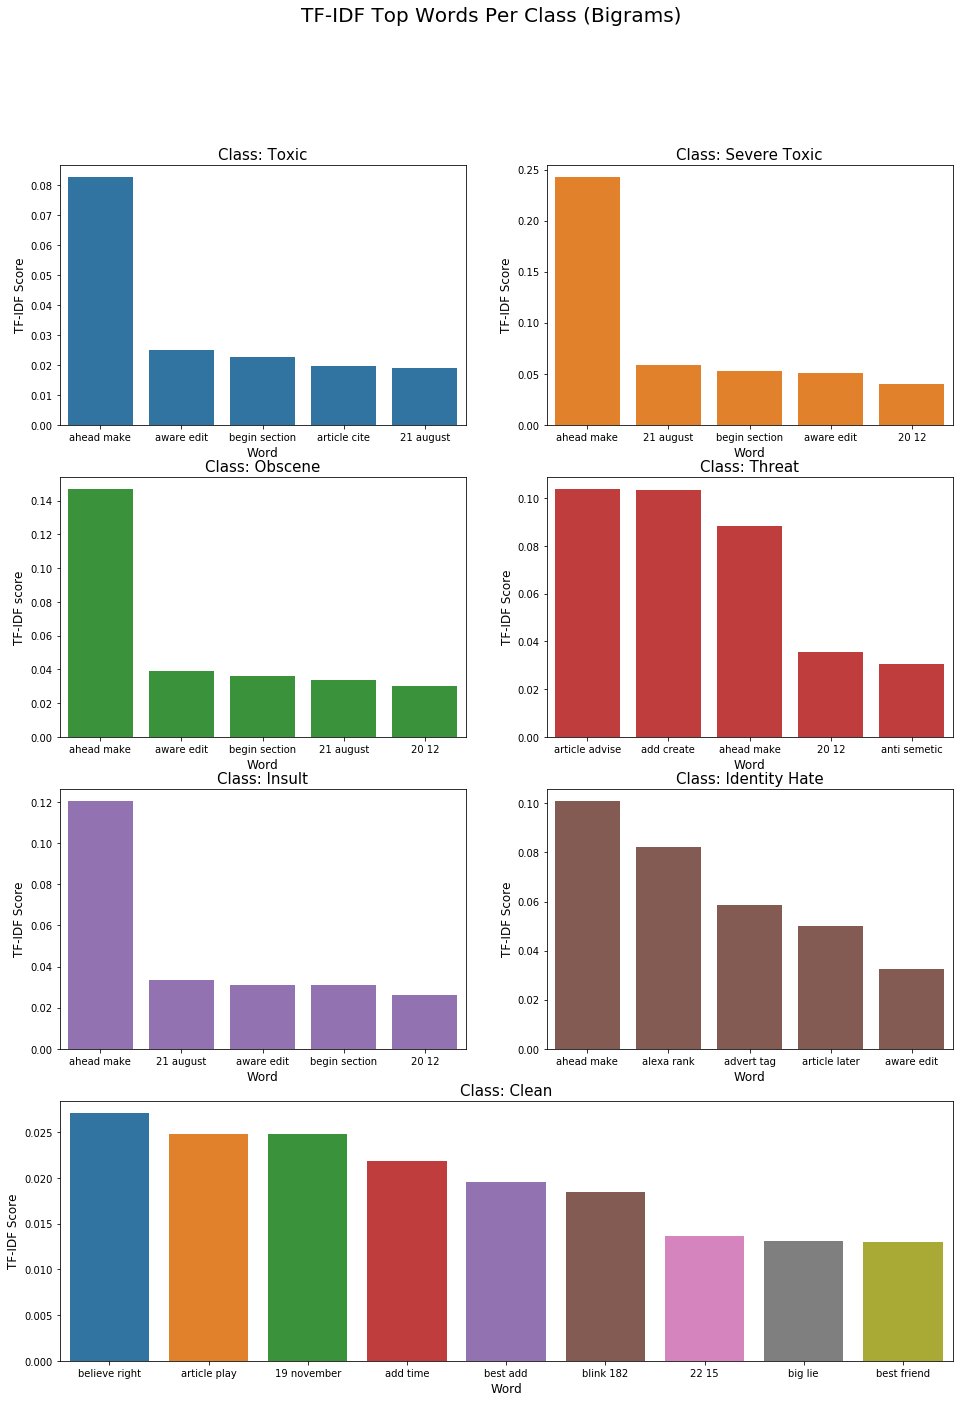

In [77]:
plt.figure(figsize=(16, 22))
plt.suptitle("TF-IDF Top Words Per Class (Bigrams)", fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2), (0,0))
sns.barplot(tfidf_top_n_per_class[0].feature.iloc[0:5],tfidf_top_n_per_class[0].tfidf.iloc[0:5],color=color[0])
plt.title("Class: Toxic", fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)

plt.subplot2grid((4,2), (0,1))
sns.barplot(tfidf_top_n_per_class[1].feature.iloc[0:5],tfidf_top_n_per_class[1].tfidf.iloc[0:5],color=color[1])
plt.title("Class: Severe Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (1,0))
sns.barplot(tfidf_top_n_per_class[2].feature.iloc[0:5],tfidf_top_n_per_class[2].tfidf.iloc[0:5],color=color[2])
plt.title("Class: Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2), (1,1))
sns.barplot(tfidf_top_n_per_class[3].feature.iloc[0:5],tfidf_top_n_per_class[3].tfidf.iloc[0:5],color=color[3])
plt.title("Class: Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (2,0))
sns.barplot(tfidf_top_n_per_class[4].feature.iloc[0:5],tfidf_top_n_per_class[4].tfidf.iloc[0:5],color=color[4])
plt.title("Class: Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (2,1))
sns.barplot(tfidf_top_n_per_class[5].feature.iloc[0:5],tfidf_top_n_per_class[5].tfidf.iloc[0:5],color=color[5])
plt.title("Class: Identity Hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)


plt.subplot2grid((4,2), (3,0), colspan=2)
sns.barplot(tfidf_top_n_per_class[6].feature.iloc[0:9],tfidf_top_n_per_class[6].tfidf.iloc[0:9])
plt.title("Class: Clean",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF Score', fontsize=12)

plt.show()

Now let's do it again for character-ngrams (specifically 1 x 4).

In [78]:
startChargrams = time.time()

tfv = TfidfVectorizer(min_df=100, max_features=30000, strip_accents='unicode', analyzer='char', ngram_range=(1,4),
                     use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_chargrams = tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_chargrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])



# Fetch top 'n' Bigrams
tfidf_top_n_per_class = top_feats_by_class(train_unigrams, features)

endChargrams = time.time()

print("Time to compute chargrams: {:.2f}".format(endChargrams - startChargrams))

Time to compute chargrams: 221.20


### Model Building

In [54]:
trainFeatures.columns

Index(['id', 'comment_text', 'sentenceCount', 'wordCount', 'uniqueWordCount',
       'letterCount', 'puncCount', 'uppercaseCount', 'titleWordCount',
       'stopwordCount', 'meanWordLength', 'wordCountPercent', 'puncPercent',
       'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'clean', 'spamRatio'],
      dtype='object')

In [55]:
SELECTED_COLS = ['sentenceCount', 'wordCount', 'uniqueWordCount', 'letterCount', 
                 'puncCount', 'uppercaseCount', 'titleWordCount','stopwordCount',
                 'meanWordLength', 'wordCountPercent', 'puncPercent']

target_x = trainFeatures[SELECTED_COLS]

TARGET_COLS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
target_y = trainTags[TARGET_COLS]

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [67]:
model = LogisticRegression(C=3)

X_train, X_valid, y_train, y_valid = train_test_split(target_x, target_y, test_size=0.33, random_state=42)

train_loss = []
valid_loss = []
importance=[]
preds_train = np.zeros((X_train.shape[0], y_train.shape[1]))
preds_valid = np.zeros((X_valid.shape[0], y_valid.shape[1]))

for i, j in enumerate(TARGET_COLS):
    print('Class: {} '.format(j))
    model.fit(X_train,y_train[j])
    preds_valid[:,i] = model.predict_proba(X_valid)[:,1]
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_loss_class=log_loss(y_train[j],preds_train[:,i])
    valid_loss_class=log_loss(y_valid[j],preds_valid[:,i])
    print('Train loss: {}'.format(train_loss_class))
    print('Valid loss {}'.format(valid_loss_class))
    importance.append(model.coef_)
    train_loss.append(train_loss_class)
    valid_loss.append(valid_loss_class)
print('mean column-wise loss (Train): {}'.format(np.mean(train_loss)))
print('mean column-wise loss (Test): {}'.format(np.mean(valid_loss)))

Class: toxic 
Train loss: 0.300165471789167
Valid loss 0.30630191101982684
Class: severe_toxic 
Train loss: 0.0504703244156193
Valid loss 0.05386711022763939
Class: obscene 
Train loss: 0.19765985673745406
Valid loss 0.2044823581603635
Class: threat 
Train loss: 0.019483600881055337
Valid loss 0.019447640168147096
Class: insult 
Train loss: 0.18726750627182095
Valid loss 0.19451203028350264
Class: identity_hate 
Train loss: 0.048675599460503566
Valid loss 0.0503283188412641
mean column-wise loss (Train): 0.1339537265926034
mean column-wise loss (Test): 0.13815656145012392


In [69]:
importance[0][0]

array([ 0.01046011,  0.01700847, -0.02371396, -0.00211528,  0.01012264,
        0.05422147, -0.02726759, -0.00327058,  0.00876836, -0.01825018,
       -0.00061301])

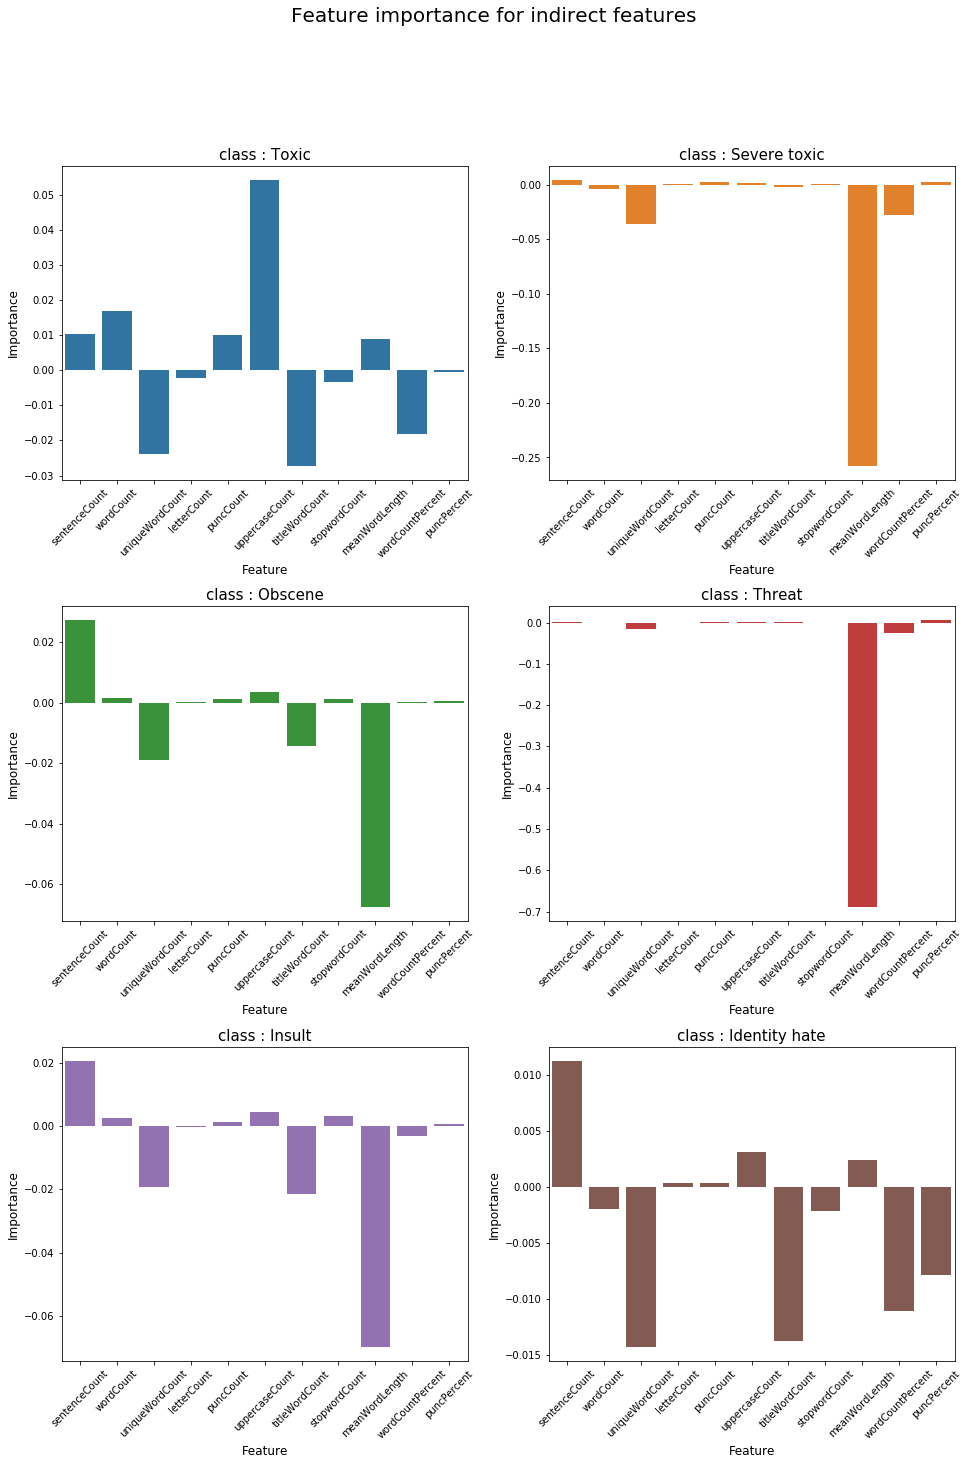

In [70]:
plt.figure(figsize=(16,22))
plt.suptitle("Feature importance for indirect features",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplots_adjust(hspace=0.4)
plt.subplot2grid((3,2),(0,0))
sns.barplot(SELECTED_COLS,importance[0][0],color=color[0])
plt.title("class : Toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(SELECTED_COLS,importance[1][0],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)

plt.subplot2grid((3,2),(1,0))
sns.barplot(SELECTED_COLS,importance[2][0],color=color[2])
plt.title("class : Obscene",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)



plt.subplot2grid((3,2),(1,1))
sns.barplot(SELECTED_COLS,importance[3][0],color=color[3])
plt.title("class : Threat",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(SELECTED_COLS,importance[4][0],color=color[4])
plt.title("class : Insult",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(SELECTED_COLS,importance[5][0],color=color[5])
plt.title("class : Identity hate",fontsize=15)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)


# plt.subplot2grid((4,2),(3,0),colspan=2)
# sns.barplot(SELECTED_COLS,importance[6][0],color=color[0])
# plt.title("class : Clean",fontsize=15)
# locs, labels = plt.xticks()
# plt.setp(labels, rotation=90)
# plt.xlabel('Feature', fontsize=12)
# plt.ylabel('Importance', fontsize=12)

plt.show()

In [71]:
X_train.head()

,sentenceCount,wordCount,uniqueWordCount,letterCount,puncCount,uppercaseCount,titleWordCount,stopwordCount,meanWordLength,wordCountPercent,puncPercent
29614,5,36,31,250,7,0,6,13,5.833333,86.11,19.44
109036,1,37,34,256,11,0,2,16,5.891892,91.89,29.73
110790,1,30,27,179,6,0,3,14,5.000000,90.00,20.00
80583,1,42,31,273,4,0,8,20,5.500000,73.81,9.52
30047,5,60,51,324,17,6,7,27,4.333333,85.00,28.33


In [72]:
y_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
29614,0,0,0,0,0,0
109036,0,0,0,0,0,0
110790,0,0,0,0,0,0
80583,0,0,0,0,0,0
30047,0,0,0,0,0,0


In [73]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

scores = []
submission = pd.DataFrame.from_dict({'id': test['id']})
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C=0.1, solver='sag')

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {}'.format(np.mean(scores)))

CV score for class toxic is 0.9692159518316337
CV score for class severe_toxic is 0.9875937877105126
CV score for class obscene is 0.9838697492305616
CV score for class threat is 0.9833766583591567
CV score for class insult is 0.9774264652937662
CV score for class identity_hate is 0.9739425621279086
Total CV score is 0.9792375290922566
